# Linear Regression: What's Driving error on the Zestimate?

## Project Planning

### Goals

(see background)...your customer is the zillow data science team.  state your goals as if you were delivering this to zillow.  They have asked for something from you (see 'background') and you are basically communicating in a more concise way, and very clearly, the goals as you understand them and as you have taken and acted upon through your research. 

*Project Overview
Background:
Zillow wants to improve their Zestimate. The zestimate is estimated value of a home. Zillow theorizes that there is more information to be gained to improve its existing model. Because of that, Zillow wants you to develop a model to predict the error between the Zestimate and the sales price of a home. In predicting the error, you will discover features that will help them improve the Zestimate estimate itself. Your goal of this project is to develop a linear regression model that will best predict the log error of the Zestimate. The error is the difference of the sales price and the Zestimate. The log error is computed by taking the log function of that error. You don't need to worry about the fact that the error is of a logarithmic function. It is a continuous number that represents an error rate.*



### Deliverables

What should the zillow team expect to receive from you?  Again, as you were communicating to them, not to your instructors.  

*your deliverables:*
1. *A report (in the form of a presentation, both verbal and through a slides) that summarizes your findings about the drivers of the Zestimate error. This will come from the analysis you do during the exploration phase of the pipeline. In the report, you will have charts that visually tell the story of what is driving the errors.*

2. *A Jupyter notebook, titled 'Regression_Proj_YourName', that contains a clearly labeled section and code clearly documented for each the stages below (project planning, data acquisition, data prep, exploration, and modeling). All of the work will take place in your jupyter notebook.*

### Data Dictionary & Details

**we will be using 2016 data so do NOT use properties_2017 or predictions_2017**  

Data dictionary of fields you will use. Why? So that you can refer back and others can refer to the meanings as you are developing your model. This is about gaining knowledge in the domain space so that you will understand when data doesn't look right, be able to more effectively develop hypotheses, and use that domain knowledge to build a more robust model (among other reasons)

Define your fields.   You may be able to to some ahead of time, but you may need to return to this section after you have explored the data and understand more about what each field means.  Also, look for a data dictionary either in the database or in the original data source (kaggle.com). 

You are free to use more fields than is mentioned, but I would recommend not expanding it to too many fields in the beginning as it will add complexity and you want to make sure you get an initial version completed before diving in deeper.  

- logerror
- bathroomcnt
- bedroomcnt
- calculatedfinishedsquarefeet
- fullbathcnt
- garagecarcnt
- roomcnt
- yearbuilt
- taxvaluedollarcnt
- taxamount

### Initial Thoughts, Ideas, Hypotheses

Brainstorming ideas, hypotheses, related to how variables might impact or relate to each other, both within independent variables and between the independent variables and dependent variable, and also related to any ideas for new features you may have while first looking at the existing variables and challenge ahead of you.

### Prepare your environment

import libraries you will use throughout the project.  You may need to add to this as you go.  But try to keep all of your imports in this section

In [214]:
import env

from helper import get_price_bin
from helper import bin_from_diff

from math import fabs

import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')

import statsmodels.api as sm

from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression

### Data Acquisition

#### Acquire via csv

- add the path to where your files are located in your env.py file. 
- ensure that others can read the files based on their local env.py file. 

- Filter out any from predictions_2016 that do not have a logerror. 
- Generate a cohesive data set that includes the following fields:

- `logerror`
- `bathroomcnt`
- `bedroomcnt`
- `calculatedfinishedsquarefeet`
- `fullbathcnt`
- `garagecarcnt`
- `roomcnt`
- `yearbuilt`
- `taxvaluedollarcnt`
- `taxamount`
- (optional) `regionidzip`

recommendations for dealing with the large dataset
- remove any without a logerror
- sample until you have the right query (and then pull entire dataset)
- export to local csv 
- read from local csv (sample, but larger sample than your first) 
- save sql query to add into to_sql() function in python. 


#### Summarize the data. 

Why? So you can confirm the data look like what you would expect.

- peek at a few rows
- data types
- summary stats
- column names
- number of rows and columns
- ...

In [215]:
# read in from the local path specified in env.py to turn our csvs into dataframes
path = env.path
properties = pd.read_csv(path + 'properties_2016.csv')
predictions = pd.read_csv(path + 'train_2016_v2.csv')

/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [216]:
# Inner join our two datasets on parcelid
df = properties.set_index('parcelid').join(predictions.set_index('parcelid'), how='inner')

In [217]:
# Let's see the first few rows of our dataframe:
df.head()


,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
parcelid,,,,,,,,,,,,,,,,,,,,,
10711738,1.0,NaN,NaN,3.0,4.0,NaN,4.0,3.0,NaN,NaN,...,245180.0,567112.0,2015.0,321932.0,7219.18,NaN,NaN,6.037113e+13,0.0276,2016-08-02
10711755,1.0,NaN,NaN,3.0,3.0,NaN,4.0,3.0,NaN,NaN,...,254691.0,459844.0,2015.0,205153.0,6901.09,NaN,NaN,6.037113e+13,-0.0182,2016-08-02
10711805,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,...,235114.0,384787.0,2015.0,149673.0,4876.61,NaN,NaN,6.037113e+13,-0.1009,2016-05-03
10711816,1.0,NaN,NaN,2.0,4.0,NaN,4.0,2.0,NaN,NaN,...,262309.0,437176.0,2015.0,174867.0,5560.07,NaN,NaN,6.037113e+13,-0.0121,2016-04-05
10711858,1.0,NaN,NaN,2.0,4.0,NaN,4.0,2.0,NaN,NaN,...,232037.0,382055.0,2015.0,150018.0,4878.25,NaN,NaN,6.037113e+13,-0.0481,2016-07-15


### Data Preparation

Goal: leave this section with a dataset that is ready to be analyzed. 

In [218]:
# Let's take a cursory look at our dataframe for integrity:
df = df[['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fullbathcnt', 'garagecarcnt', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'taxamount']]
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 10711738 to 162960842
Data columns (total 10 columns):
logerror                        90275 non-null float64
bathroomcnt                     90275 non-null float64
bedroomcnt                      90275 non-null float64
calculatedfinishedsquarefeet    89614 non-null float64
fullbathcnt                     89093 non-null float64
garagecarcnt                    29937 non-null float64
roomcnt                         90275 non-null float64
yearbuilt                       89519 non-null float64
taxvaluedollarcnt               90274 non-null float64
taxamount                       90269 non-null float64
dtypes: float64(10)
memory usage: 7.6 MB


#### Identify the columns that have missing values and the number of missing values in each column. 
Why? Missing values are going to cause issues down the line so you will need to handle those appropriately. For each variable with missing values, if it makes sense to replace those missing with a 0, do so. For those where that doesn't make sense, decide if you should drop the entire observations (rows) that contain the missing values, or drop the entire variable (column) that contains the missing values.

### -Noting from our info on the initial dataframe, we see that our garagecarcnt column is filled only by a 1/3 ratio of the entire data set.  It would be largely unknowable to fill the rest of this column with data, so I have deemed it unusable in this instance and will drop the column.  The other null entries in our columns have less than 2% of data missing at most, and I find it most pragmatic to merely drop the rows in this instance.

In [219]:
df.drop(columns='garagecarcnt', inplace = True)

In [220]:
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88998 entries, 10711738 to 162960842
Data columns (total 9 columns):
logerror                        88998 non-null float64
bathroomcnt                     88998 non-null float64
bedroomcnt                      88998 non-null float64
calculatedfinishedsquarefeet    88998 non-null float64
fullbathcnt                     88998 non-null float64
roomcnt                         88998 non-null float64
yearbuilt                       88998 non-null float64
taxvaluedollarcnt               88998 non-null float64
taxamount                       88998 non-null float64
dtypes: float64(9)
memory usage: 6.8 MB


In [221]:
#Using sorting to remove inplausible outliers: 
# bed/bath values with sqft too small to accomodate
# property assessments that are the price of a meal
df.sort_values(by = 'calculatedfinishedsquarefeet')
df = df[df.calculatedfinishedsquarefeet > 155]
df.sort_values(by = 'taxvaluedollarcnt')
df = df[df.taxvaluedollarcnt > 5000]
df.sort_values(by = 'taxvaluedollarcnt')
df.sort_values(by = 'yearbuilt').head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount
parcelid,,,,,,,,,
11764365,0.0325,1.0,2.0,736.0,1.0,0.0,1885.0,233500.0,2123.25
12883734,0.0478,1.0,2.0,756.0,1.0,0.0,1885.0,235614.0,3069.50
11778471,0.1222,3.0,6.0,2953.0,3.0,0.0,1885.0,529254.0,6899.32
12171626,-0.0305,1.0,5.0,3340.0,1.0,0.0,1885.0,708373.0,8478.10
12105155,0.1098,1.0,2.0,969.0,1.0,0.0,1885.0,29730.0,575.35


In [222]:
df[df.roomcnt == 0].count()

logerror                        68482
bathroomcnt                     68482
bedroomcnt                      68482
calculatedfinishedsquarefeet    68482
fullbathcnt                     68482
roomcnt                         68482
yearbuilt                       68482
taxvaluedollarcnt               68482
taxamount                       68482
dtype: int64

In [223]:
summary = df.describe()
summary

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,roomcnt,yearbuilt,taxvaluedollarcnt,taxamount
count,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,8.899300e+04,88993.000000
mean,0.011443,2.308710,3.069612,1768.417505,2.240693,1.495039,1968.584844,4.576148e+05,5972.910552
std,0.158212,0.973797,1.109416,923.704678,0.960686,2.830576,23.766493,5.533956e+05,6804.212417
min,-4.605000,1.000000,0.000000,199.000000,1.000000,0.000000,1885.000000,7.704000e+03,49.080000
25%,-0.025300,2.000000,2.000000,1182.000000,2.000000,0.000000,1953.000000,2.004130e+05,2881.660000
50%,0.006000,2.000000,3.000000,1537.000000,2.000000,0.000000,1970.000000,3.436600e+05,4544.760000
75%,0.038300,3.000000,4.000000,2089.000000,3.000000,0.000000,1987.000000,5.405890e+05,6893.200000
max,4.737000,15.000000,16.000000,22741.000000,15.000000,18.000000,2015.000000,2.775000e+07,321936.090000


### based on the description of the dataframe, there is clearly an issue with our room count integrity.  Let's explore it further:

In [224]:
df[df.roomcnt == 0].count()

logerror                        68482
bathroomcnt                     68482
bedroomcnt                      68482
calculatedfinishedsquarefeet    68482
fullbathcnt                     68482
roomcnt                         68482
yearbuilt                       68482
taxvaluedollarcnt               68482
taxamount                       68482
dtype: int64

68482 of our rows have zero rooms listed.  This may be possible for empty lots, but the vast majority of these properties are not.  We will disregard the column.

In [225]:
df.drop(columns='roomcnt', inplace = True)

In [226]:
summary = df.describe()
summary

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
count,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,8.899300e+04,88993.000000
mean,0.011443,2.308710,3.069612,1768.417505,2.240693,1968.584844,4.576148e+05,5972.910552
std,0.158212,0.973797,1.109416,923.704678,0.960686,23.766493,5.533956e+05,6804.212417
min,-4.605000,1.000000,0.000000,199.000000,1.000000,1885.000000,7.704000e+03,49.080000
25%,-0.025300,2.000000,2.000000,1182.000000,2.000000,1953.000000,2.004130e+05,2881.660000
50%,0.006000,2.000000,3.000000,1537.000000,2.000000,1970.000000,3.436600e+05,4544.760000
75%,0.038300,3.000000,4.000000,2089.000000,3.000000,1987.000000,5.405890e+05,6893.200000
max,4.737000,15.000000,16.000000,22741.000000,15.000000,2015.000000,2.775000e+07,321936.090000


tax amount clearly has some outliers, but we will leave them in  momentarily as they may well be accurate due to tax exemptions

In [227]:
# calculate inner quartile range on dataframe:
summary.loc['iqr'] = summary.loc['75%']-summary.loc['25%']
summary

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
count,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,88993.000000,8.899300e+04,88993.000000
mean,0.011443,2.308710,3.069612,1768.417505,2.240693,1968.584844,4.576148e+05,5972.910552
std,0.158212,0.973797,1.109416,923.704678,0.960686,23.766493,5.533956e+05,6804.212417
min,-4.605000,1.000000,0.000000,199.000000,1.000000,1885.000000,7.704000e+03,49.080000
25%,-0.025300,2.000000,2.000000,1182.000000,2.000000,1953.000000,2.004130e+05,2881.660000
50%,0.006000,2.000000,3.000000,1537.000000,2.000000,1970.000000,3.436600e+05,4544.760000
75%,0.038300,3.000000,4.000000,2089.000000,3.000000,1987.000000,5.405890e+05,6893.200000
max,4.737000,15.000000,16.000000,22741.000000,15.000000,2015.000000,2.775000e+07,321936.090000
iqr,0.063600,1.000000,2.000000,907.000000,1.000000,34.000000,3.401760e+05,4011.540000


#### Create a variable, `colnames`, that is a list of the column names. 
Why? You will likely reference this variable later.

In [228]:
colnames = [col for col in df]
colnames

['logerror',
 'bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'taxamount']

#### Identify the data types of each variable. Why? 
You need to make sure they are what makes sense for the data and the meaning of the data that lies in that variable. If it does not, make necessary changes.

In [229]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88993 entries, 10711738 to 162960842
Data columns (total 8 columns):
logerror                        88993 non-null float64
bathroomcnt                     88993 non-null float64
bedroomcnt                      88993 non-null float64
calculatedfinishedsquarefeet    88993 non-null float64
fullbathcnt                     88993 non-null float64
yearbuilt                       88993 non-null float64
taxvaluedollarcnt               88993 non-null float64
taxamount                       88993 non-null float64
dtypes: float64(8)
memory usage: 6.1 MB


### All of our data is represented as float values, which is useful for analysis.  Nothing here should be a string object.

#### Create a list of the independent variable names (aka attributes) and assign it to `x_vars` 
Why? During exploration, you will likely use this list to refer to the attribute names.

In [230]:
x_vars = colnames[1:]
x_vars

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'fullbathcnt',
 'yearbuilt',
 'taxvaluedollarcnt',
 'taxamount']

#### Clearly identify your dependent (target) variable. 
- What is the name of the variable? 
- Is it discrete or continuous?

### -Our target variable is logerror.  It is continuousv(a log function applied to the residual of error in the zestimate)

#### View the distribution of the numeric variables
- plot a histogram and box plot of each variable. 
- Why? To see the distribution, skewness, outliers, and unit scales. You will use this information in your decision of whether to normalize, standardize or neither.

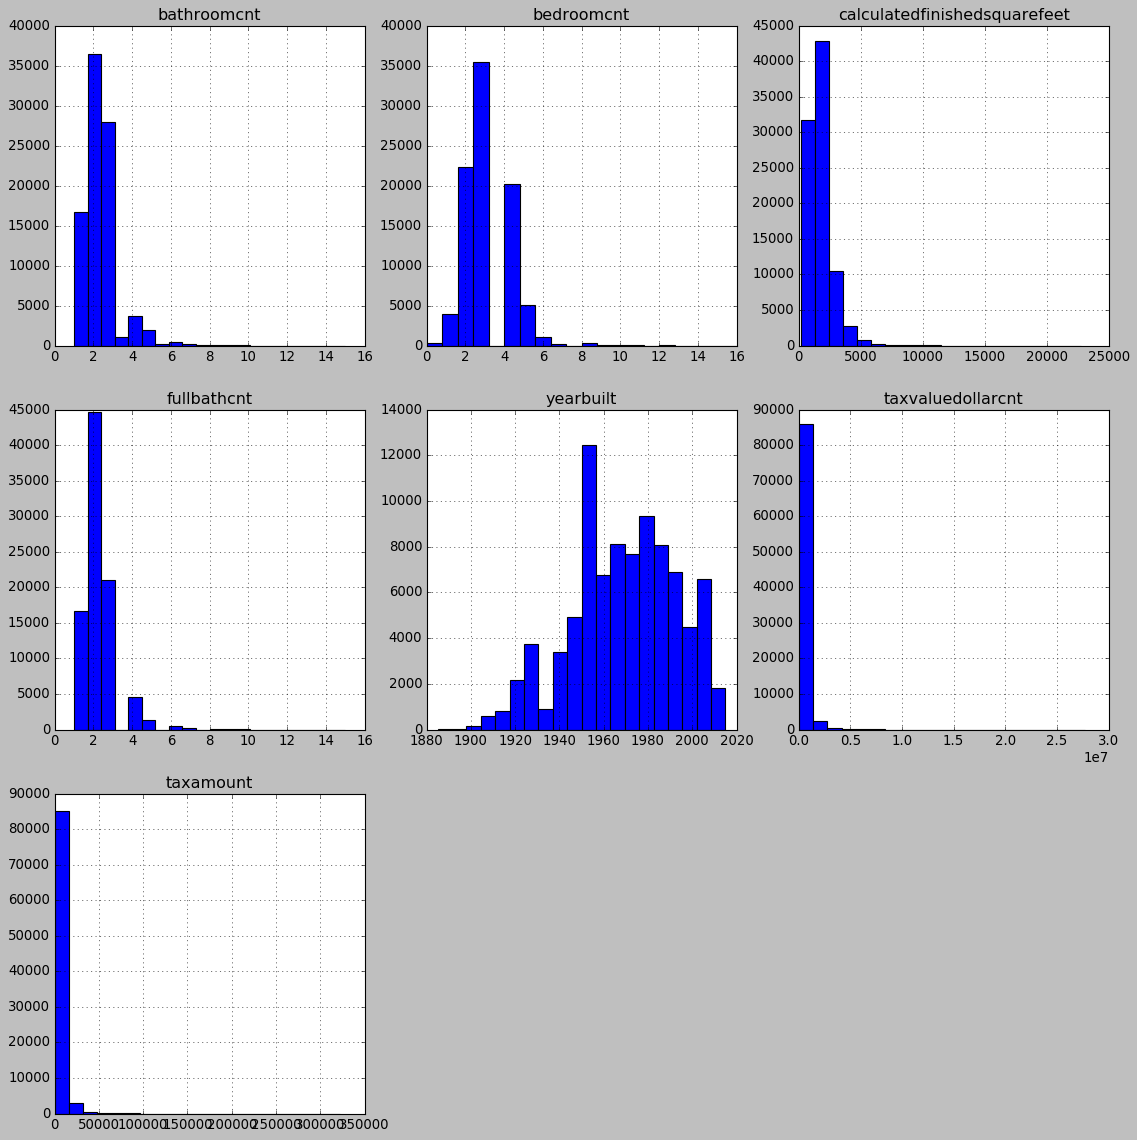

In [231]:
plt.figure(figsize=(17,17))
for i, col in enumerate(x_vars):
    plot_number = i+1
    series = df[col]
    plt.subplot(3, 3, plot_number)
    plt.title(col)
    series.hist(bins=20, density=False, cumulative=False, log=False)
    


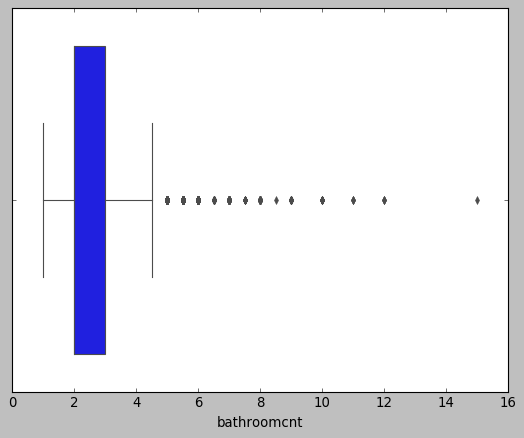

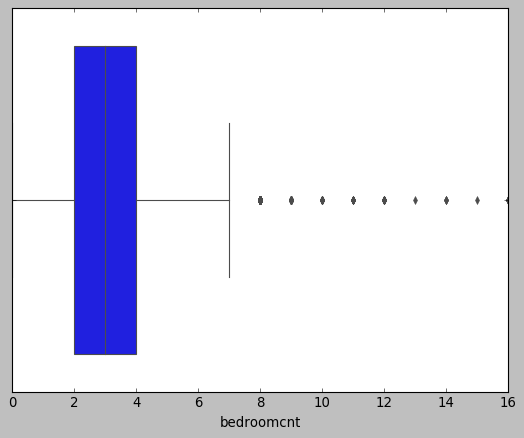

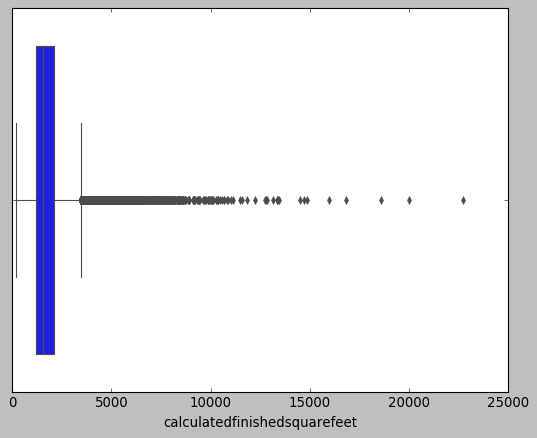

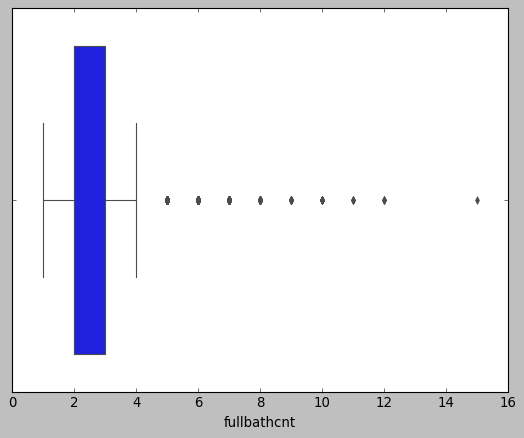

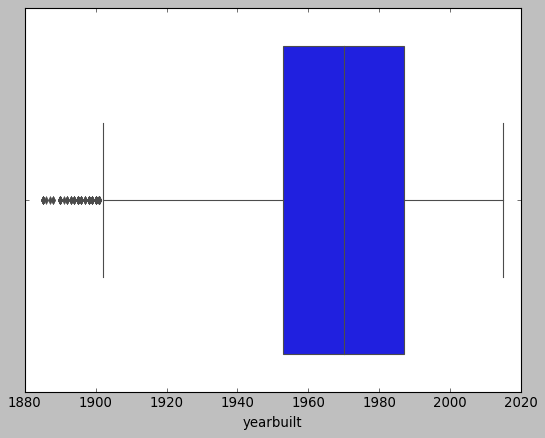

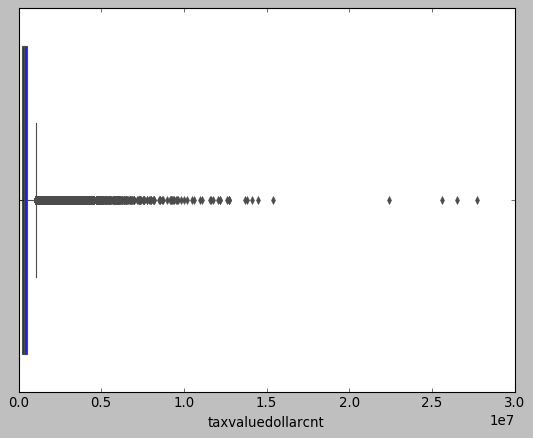

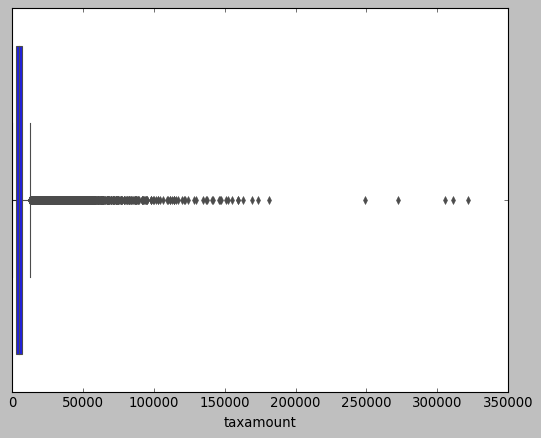

In [232]:
for i, col in enumerate(x_vars):
    series = df[col]
    sns.boxplot(series, orient='h')
    plt.show()

### Data Exploration

Goal is to address each of the questions you posed in your planning & brainstorming through visual or statistical analysis.

When you have completed this step, you will have the findings from your analysis that will be used in your final report, the answers to your questions and your customer's questions that will reach the goal. 

#### Split data into training and test datasets

In [233]:
X = df.drop(['logerror'], axis = 1)
y = df[['logerror']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


#### Create a jointplot for each independent variable (normalized version) with the dependent variable. 

Be sure you have Pearson's r and p-value annotated on each plot.

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWa

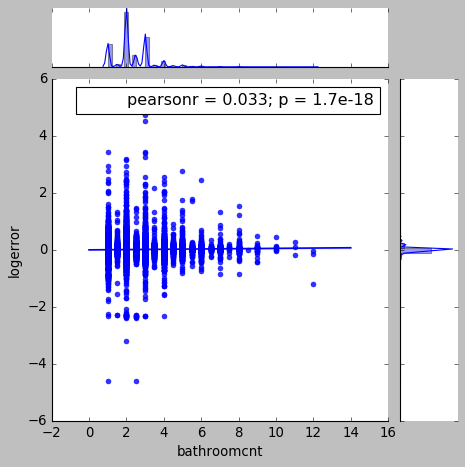

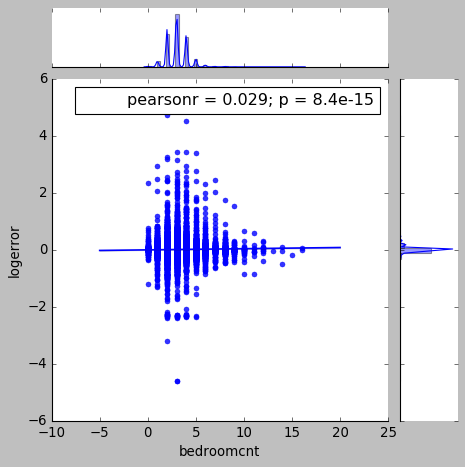

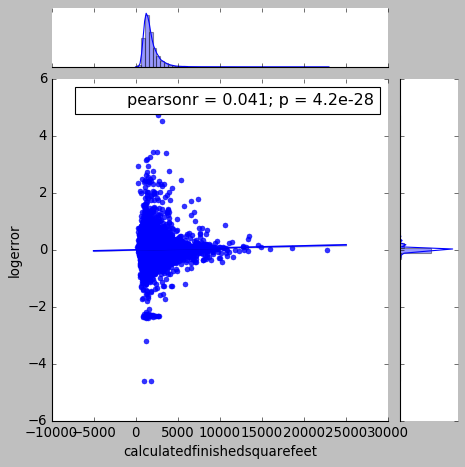

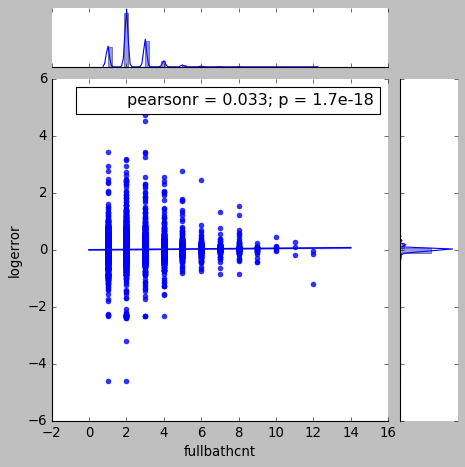

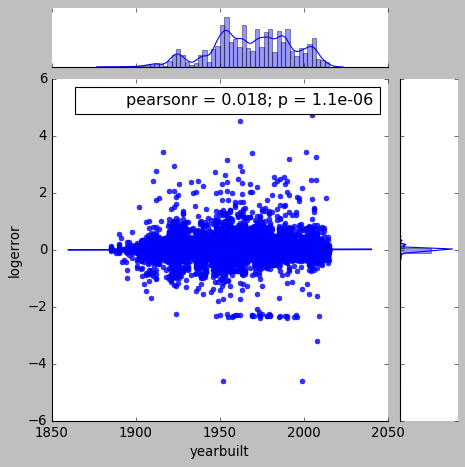

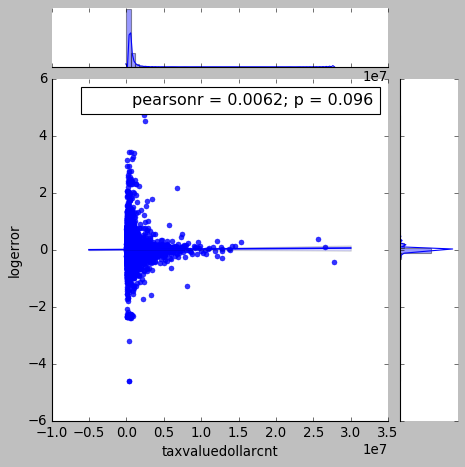

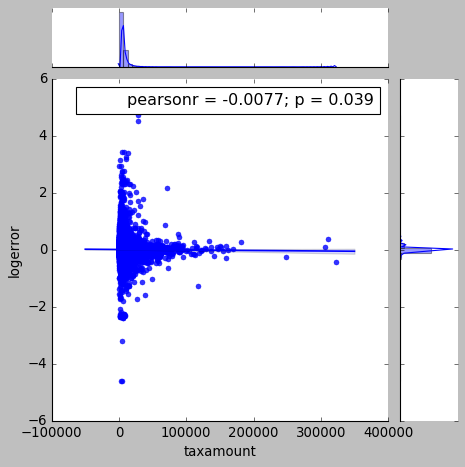

In [234]:
for i, col in enumerate(x_vars):
    j = sns.jointplot(col, 'logerror', data = train, kind='reg')
    j.annotate(stats.pearsonr)

### <span style="color:green">We can note from these plots that the distribution of error is largely symmetric  from a negative to positive scale.  Because we are not particularly interested in this instance if that error is over or under estimating, we will push forward with just the absolute value of the logerror, giving us a clearer image of the magnitude of the error and preventing us from negating values when attempting to find pearson's r in correlations</span>

In [235]:
df.head()

,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount
parcelid,,,,,,,,
10711738,0.0276,3.0,4.0,2538.0,3.0,1978.0,567112.0,7219.18
10711755,-0.0182,3.0,3.0,1589.0,3.0,1959.0,459844.0,6901.09
10711805,-0.1009,2.0,3.0,2411.0,2.0,1973.0,384787.0,4876.61
10711816,-0.0121,2.0,4.0,2232.0,2.0,1973.0,437176.0,5560.07
10711858,-0.0481,2.0,4.0,1882.0,2.0,1973.0,382055.0,4878.25


In [236]:
df['abs_logerr'] = df.logerror.apply(fabs)

In [237]:
# re-split:
X = df.drop(['logerror', 'abs_logerr'], axis = 1)
y = df[['abs_logerr']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

#### Create a feature plot using seaborn's PairGrid() of the interaction between each variable (dependent + independent). 

You may want to use a normalized dataframe (if you did that) or adjust the axis scale (set to logarithmic, e.g) so you can more clearly view the interactions.

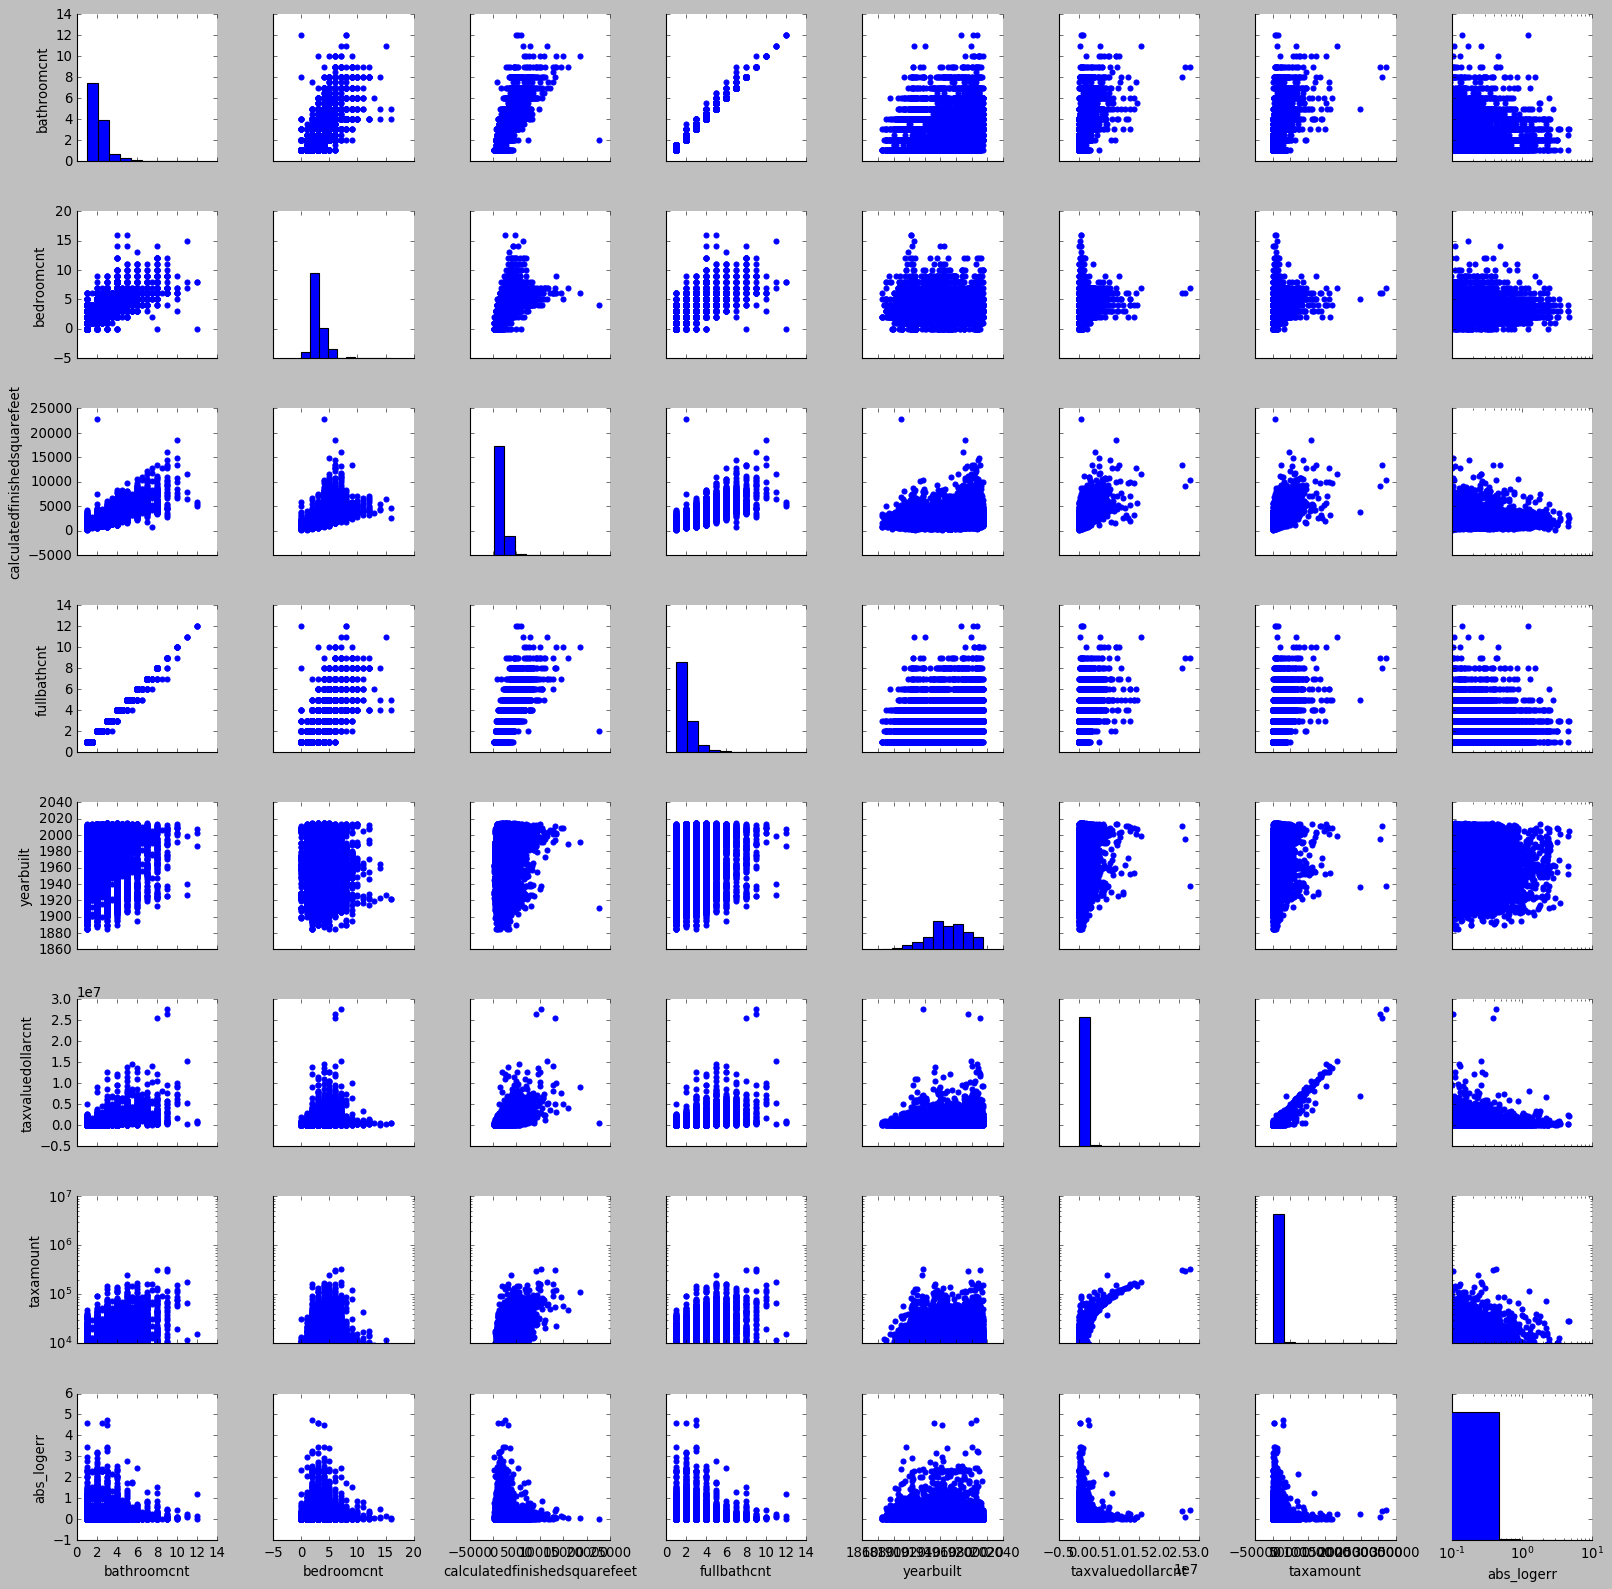

In [238]:
g = sns.PairGrid(train)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.xscale('log')
plt.yscale('log')

#### Create a heatmap of the correlation between each variable pair.

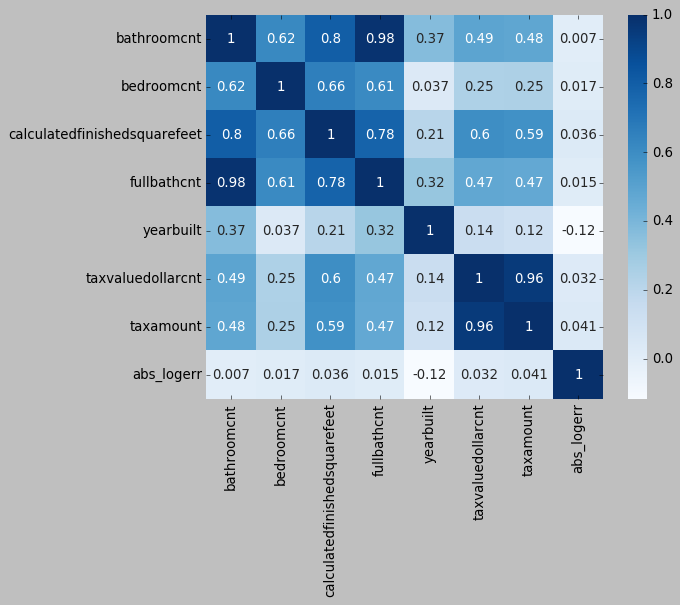

In [239]:
sns.heatmap(train.corr(), cmap='Blues', annot=True)

#### Summarize your conclusions from all of these steps.  

In [240]:
ols_model = sm.OLS(y_train, X_train)
fit = ols_model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             abs_logerr   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     2340.
Date:                Sun, 24 Mar 2019   Prob (F-statistic):               0.00
Time:                        11:29:28   Log-Likelihood:                 38209.
No. Observations:               71194   AIC:                        -7.640e+04
Df Residuals:                   71187   BIC:                        -7.634e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathroomcnt                     -0.0488      0.003    -15.119      0.000      -0.055      -0.043
bedroomcnt                       0.0002      0.001      0.326      0.744      -0.001       0.002
calculatedfinishedsquarefeet  1.203e-05   1.15e-06     10.430      0.000    9.77e-06    1.43e-05
fullbathcnt                      0.0402      0.003     12.828      0.000       0.034       0.046
yearbuilt                     3.244e-05   8.49e-07     38.217      0.000    3.08e-05    3.41e-05
taxvaluedollarcnt            -2.059e-08   3.29e-09     -6.265      0.000    -2.7e-08   -1.41e-08
taxamount                     2.205e-06   2.65e-07      8.337      0.000    1.69e-06    2.72e-06
==============================================================================
Omnibus:                   112948.794   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         92384557.792
Skew:                          10.240   Prob(JB):                         0.00
Kurtosis:                     178.283   Cond. No.                     6.07e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <span style="color:green">Looking at our OLS summary of correlations, we can certainly find variables correlated with eachother, though our correlation coefficients are woefully low for logerror.  We will need to do some feature engineering if we are to glean any meaningful conclusions from this</span>

### Is the logerror significantly different for homes with 3 bedrooms vs those with 5 or more bedrooms? 
Run a t-test to test this difference.

In [241]:
three_bed = train[train.bedroomcnt == 3]
five_bed = train[train.bedroomcnt >= 5]
from scipy.stats import ttest_ind
ttest_ind(three_bed.abs_logerr, five_bed.abs_logerr)

Ttest_indResult(statistic=-11.642886147394071, pvalue=2.8619535123904535e-31)

### Do the same for another 2 samples you are interested in comparing (e.g. those with 1 bath vs. x baths)

In [242]:
# compare properties with 4 or more bathrooms vs those with less
train4bath = train[train.bathroomcnt >= 4]
trainlessbath = train[train.bathroomcnt < 4]
trainlessbath.head()
print(ttest_ind(trainlessbath.abs_logerr, train4bath.abs_logerr))
print('t value less than -1.96 and pvalue smaller than 0.05.  We can say there is a correlation in error here.')

Ttest_indResult(statistic=-15.565419938074847, pvalue=1.5386129577160282e-54)
t value less than -1.96 and pvalue smaller than 0.05.  We can say there is a correlation in error here.


### Are there new features you could create based on existing features that might be helpful? Come up with at least one possible new feature that is a calculation from 2+ existing variables.

In [251]:
train['bed_bath'] = train.bedroomcnt + train.bathroomcnt
train.head()

,diff_from_mean_class,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount,price_bin,diff_from_mean,abs_logerr,total_bath,bed_bath
2,3.0,2.212121,2.965657,1553.224531,2.134488,1969.782395,369921.979509,4776.043625,4.00000,87692.795259,0.056967,5.177778,5.177778
14,15.0,1.834460,3.009103,1407.340962,1.813784,1955.535761,69753.050975,1835.951347,NaN,387861.723794,0.080511,4.843563,4.843563
12,13.0,1.936589,2.807392,1445.141404,1.906748,1963.496100,120197.696168,2370.659739,NaN,337417.078601,0.082761,4.743981,4.743981
3,4.0,2.158344,2.953538,1533.736182,2.085180,1969.249132,345154.907877,4512.050828,3.31028,112459.866892,0.055839,5.111883,5.111883
6,7.0,2.073989,2.849225,1465.072464,2.025172,1967.418002,270245.517162,3702.319484,2.00000,187369.257606,0.061992,4.923214,4.923214


### <span style="color:green">Our t-test shows that there is a notable difference in the means of these two groups of properties.  Let's investigate this further.  Try grouping our data by bathroomcount:</span>

Correlation: 
-0.9879225666773224


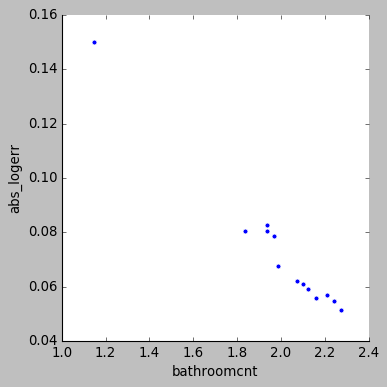

In [252]:
bathroomcnt_err = train[['abs_logerr', 'bathroomcnt']].groupby('bathroomcnt', as_index=False).mean().sort_values(by='abs_logerr', ascending=False)
bathroomcnt_err
sns.relplot(data = bathroomcnt_err, x='bathroomcnt', y = 'abs_logerr')
print('Correlation: ')
print(bathroomcnt_err[['bathroomcnt', 'abs_logerr']].corr().min()[0])
                      

### <span style="color:green"> We have a linear correlation! Let's attempt another grouping. </span>

Correlation: 
0.8038904440451333


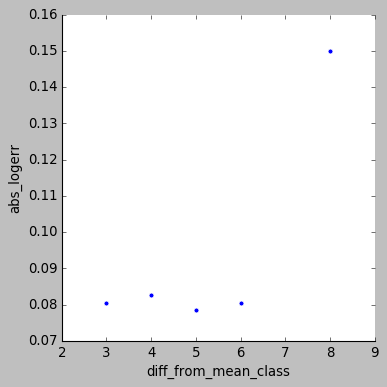

In [253]:
train['price_bin'] = train.taxvaluedollarcnt.apply(get_price_bin)
train['diff_from_mean'] = train.taxvaluedollarcnt.mean() - train.taxvaluedollarcnt
train['diff_from_mean_class'] = train.diff_from_mean.apply(bin_from_diff)
diff_price = train[['abs_logerr', 'diff_from_mean_class']].groupby('diff_from_mean_class', as_index=False).mean().sort_values(by='abs_logerr', ascending=False)
sns.relplot(data = diff_price, x='diff_from_mean_class', y = 'abs_logerr')

print('Correlation: ')
print(diff_price[['diff_from_mean_class', 'abs_logerr']].corr().min()[0])




### <span style="color:green"> Wow! almost a 0.85 estimated correlation! Very impressive! Now, this is data we could build a model on!! </span>

### Build new train/test split based on price difference groups applied to our initial dataset:

In [254]:
df['price_bin'] = df.taxvaluedollarcnt.apply(get_price_bin)
df['diff_from_mean'] = df.taxvaluedollarcnt.mean() - df.taxvaluedollarcnt
df['diff_from_mean_class'] = df.diff_from_mean.apply(bin_from_diff)
df_diff_price = df.groupby('diff_from_mean_class', as_index=False).mean().sort_values(by='abs_logerr', ascending=False)

Xd = df_diff_price.drop(['logerror', 'abs_logerr'], axis=1)
yd = df_diff_price[['abs_logerr']]
X_traind, X_testd, y_traind, y_testd = train_test_split(Xd, yd, train_size=.80, random_state=0)

train = pd.concat([X_traind, y_traind], axis=1)
test = pd.concat([X_testd, y_testd], axis=1)

train.head()


,diff_from_mean_class,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fullbathcnt,yearbuilt,taxvaluedollarcnt,taxamount,price_bin,diff_from_mean,abs_logerr
2,3.0,2.212121,2.965657,1553.224531,2.134488,1969.782395,369921.979509,4776.043625,4.00000,87692.795259,0.056967
14,15.0,1.834460,3.009103,1407.340962,1.813784,1955.535761,69753.050975,1835.951347,NaN,387861.723794,0.080511
12,13.0,1.936589,2.807392,1445.141404,1.906748,1963.496100,120197.696168,2370.659739,NaN,337417.078601,0.082761
3,4.0,2.158344,2.953538,1533.736182,2.085180,1969.249132,345154.907877,4512.050828,3.31028,112459.866892,0.055839
6,7.0,2.073989,2.849225,1465.072464,2.025172,1967.418002,270245.517162,3702.319484,2.00000,187369.257606,0.061992


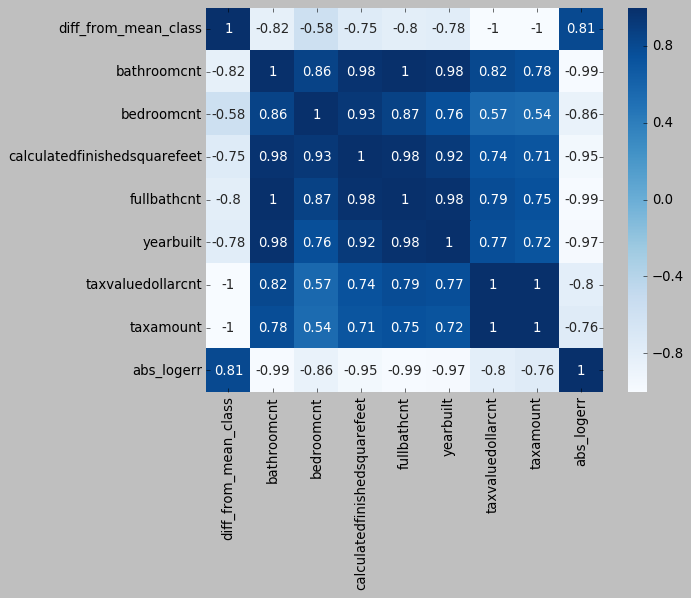

In [260]:
train.drop(['price_bin', 'diff_from_mean'], axis=1, inplace=True)
sns.heatmap(train.corr(), cmap='Blues', annot=True)



## Train and Test Model
## Fit, predict (in-sample) & evaluate multiple linear regression models to find the best one.

- Make any changes as necessary to improve your model.

- Identify the best model after all training

- Compare the models by plotting the predictions of each model with actual values (see plot right above section 12 in 'Regression in Python' lesson

In [ ]:
lm_avg_price = LinearRegression()
lm_avg_price.fit(X_traind[['diff_from_mean_class']], y_traind)
y_pred_lmd = lm_avg_price.predict(X_traind[['diff_from_mean_class']])

In [ ]:
mse_lmavg_price = mean_squared_error(y_traind, y_pred_lmd)
print(f'Mean Squared Error for  lmd: {mse_lmavg_price}')

r2_lmd = r2_score(y_traind, y_pred_lmd)
print(f'r^2 for lmd: {r2_lmd}')

lmd_y_intercept = lm_avg_price.intercept_
print('Y intercept for lmd: {}'.format(lmd_y_intercept[0]))

print('slope of lmd: {}'.format(lm_avg_price.coef_[0][0]))

In [ ]:
lmd_2 = LinearRegression()
lmd_2.fit(X_traind[['bathroomcnt']], y_traind)
y_pred_lmd_2 = lmd_2.predict(X_traind[['bathroomcnt']])

In [ ]:
#linear model #2 intuitively from our heatmap:
# based on bathroom counts for homes
mse_lmd_2 = mean_squared_error(y_traind, y_pred_lmd_2)
print(f'Mean Squared Error for  lmd: {mse_lmd_2}')

r2_lmd_2 = r2_score(y_traind, y_pred_lmd_2)
print(f'r^2 for lmd: {r2_lmd_2}')

lmd_2_y_intercept = lm_avg_price.intercept_
print('Y intercept for lmd: {}'.format(lmd_2_y_intercept[0]))

print('slope of lmd: {}'.format(lmd_2.coef_[0][0]))

In [ ]:
# let's compund these models:
lmd_3 = LinearRegression()
lmd_3.fit(X_traind[['diff_from_mean_class','bathroomcnt']], y_traind)
y_pred_lmd_3 = lmd_3.predict(X_traind[['diff_from_mean_class', 'bathroomcnt']])

mse_lmd_3 = mean_squared_error(y_traind, y_pred_lmd_3)
print(f'Mean Squared Error for  lmd: {mse_lmd_3}')

r2_lmd_3 = r2_score(y_traind, y_pred_lmd_3)
print(f'r^2 for lmd: {r2_lmd_3}')

lmd_3_y_intercept = lm_avg_price.intercept_
print('Y intercept for lmd: {}'.format(lmd_3_y_intercept[0]))

print('slope of lmd: {}'.format(lmd_3.coef_[0][0]))

#### Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target

#### Summarize your conclusions and next steps from your analysis in above. 
What will you try when developing your model? (which features to use/not use/etc)

#### Train & Test Model


# Model on Test Data:

In [ ]:
y_pred_lmd_test = lm_avg_price.predict(X_testd[['diff_from_mean_class']])
mse_lmd_tst = mean_squared_error(y_testd, y_pred_lmd_test)
print(f'mean squared error for lmd on test data: {mse_lmd_tst}')

r2_lmd_tst = r2_score(y_testd, y_pred_lmd_test)
print('{:.2%} of the variance in the average absolute log error can be explained by the difference of the tax assessed house price by bins of 25,000.'
      .format(r2_lmd_tst))

## Predict & evaluate on out-of-sample data (test)    

- Plot the residuals from your out-of-sample predictions.

- Summarize your expectations about how you estimate this model will perform in production.

In [ ]:
#Residual Plot
plt.scatter(y_pred_lmd_test, y_pred_lmd_test - y_testd, c='g', s=40)
plt.hlines(y=0, xmin=0, xmax=0.12)
plt.title("Residuals on Test for Model 1: (Difference class only)")

In [ ]:
pd.DataFrame({'actual': y_testd.abs_logerr,
              'lm1': y_pred_lmd_test.ravel()})\
    .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
    .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

plt.title('Predicted vs Actual Average Absolute log Error Model 1')
plt.plot([0.05, 0.1], [0.0065, 0.105], c='black', ls=':')

In [ ]:
slope = lm_avg_price.coef_[0][0]

plt_df = pd.DataFrame({'Average_Absolute_Value_Log_Error': y_testd.abs_logerr,
              'Difference_From_Mean_By_Class_of_25000': X_testd.diff_from_mean_class,
              })
plt.scatter(plt_df.Difference_From_Mean_By_Class_of_25000, plt_df.Average_Absolute_Value_Log_Error)
x = range(0, 18)
plt.plot(x, [slope*n for n in x], c = 'red', ls=':')
plt.title('Linear Reg for Log Error vs Actual Log Error Model 1')
plt.ylim(0, 0.12)
plt.xlim(0, 18)
plt.show()
